In [1]:
%matplotlib inline
import composeml as cp
import pandas as pd

In [2]:
PARTITION = '100'
BASE_DIR = 's3://customer-churn-spark/'
PARTITION_DIR = BASE_DIR + 'p' + PARTITION
transactions = f'{PARTITION_DIR}/transactions.csv'

In [3]:
transactions = pd.read_csv(
    transactions,
    parse_dates=['transaction_date', 'membership_expire_date'],
    infer_datetime_format=True,
)
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,G7TmHc9Gg2t8ovG/KFaB53We/0CQPELhZ5UUN2Ol3AQ=,39,30,149,149,1,2015-09-30,2015-11-13,0
1,LPbp8N7VRuqEISEVim8ppTaeYJG/rWS/t4g/dEFuWjw=,34,30,149,149,1,2016-02-29,2016-03-31,0
2,xvYqULBWzJvN8heyFtY3hbY3egyQNbXuDx0igtsoi00=,29,30,180,180,1,2017-01-31,2017-03-01,0
3,UR4iin4mAkajoa7o+AyTTmz5k3N2GR3/rZY8a4KwADI=,41,30,99,99,1,2017-01-31,2017-02-28,0
4,ax8CRhY8BMRA/ZvT1wI+2N/EdPXiSPGxa9y7bntA1Uc=,40,30,149,149,1,2016-05-04,2016-06-08,0


In [4]:
def inactive_membership(transactions):
    if len(transactions) != 2: return

    membership_expire_date = transactions['membership_expire_date']
    membership_expire_date = membership_expire_date.iloc[0]

    next_transaction_date = transactions.index[1]
    inactive = next_transaction_date - membership_expire_date
    return inactive

In [5]:
label_maker = cp.LabelMaker(
    target_entity='msno',
    time_index='transaction_date',
    labeling_function=inactive_membership,
    window_size=2,
)

In [6]:
label_times = label_maker.search(
    transactions,
    minimum_data=0,
    num_examples_per_instance=2,
    gap=1,
    verbose=True,
)
label_times.head()

Elapsed: 00:19 | Remaining: 00:00 | Progress: 100%|██████████| msno: 4978/4978 


,msno,cutoff_time,inactive_membership
label_id,,,
0,+SUahxuFAKw3huqlBfGVgvT44+PPt/RmZ7gPbryku/I=,2015-08-26,12 days
1,+YHiQZnhoPgINzgyF6O0FtCBrvONxNPQa/rejx+iRtA=,2015-04-10,62 days
2,+ZGOhh48XZaM5m+IDuLtIIpWJDW5ID+I5xUNOjhuJ8Q=,2016-01-31,-1 days
3,+aOmhHp8AiRAK1eBO/JyXD9uspw6U+F1nNQmEgZZDZ4=,2016-11-15,2 days
4,+pBGf1aacFXTWVw3k0cdD3m8acnAfmn8uIGU1lAs1tQ=,2015-12-05,-5 days


In [7]:
one_month = pd.Timedelta('31d')
is_churn = label_times.threshold(one_month)
is_churn = is_churn.apply_lead(one_month)
is_churn.head()

,msno,cutoff_time,inactive_membership
label_id,,,
0,+SUahxuFAKw3huqlBfGVgvT44+PPt/RmZ7gPbryku/I=,2015-07-26,False
1,+YHiQZnhoPgINzgyF6O0FtCBrvONxNPQa/rejx+iRtA=,2015-03-10,True
2,+ZGOhh48XZaM5m+IDuLtIIpWJDW5ID+I5xUNOjhuJ8Q=,2015-12-31,False
3,+aOmhHp8AiRAK1eBO/JyXD9uspw6U+F1nNQmEgZZDZ4=,2016-10-15,False
4,+pBGf1aacFXTWVw3k0cdD3m8acnAfmn8uIGU1lAs1tQ=,2015-11-04,False


Label Distribution
------------------
False     470
True       61
Total:    531


Settings
--------
num_examples_per_instance    2
minimum_data                 0
window_size                  2
gap                          1


Transforms
----------
1. threshold
  - value:    31 days 00:00:00

2. apply_lead
  - value:    31 days 00:00:00



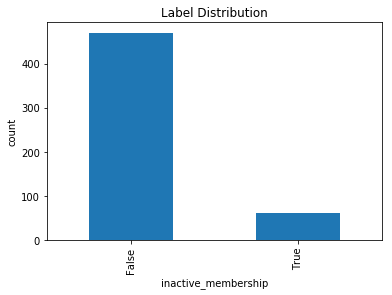

In [9]:
is_churn.describe()
is_churn.plot.distribution()